# Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

Probability of converting regardless of page is 0.119

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
e=len(df.query('landing_page =="new_page" and group !="treatment"'))+len(df.query('landing_page !="new_page" and group =="treatment"'))
e

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2=df.copy()
df2=df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) != False]
df2=df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) != False]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
(df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0],
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0])

(0, 0)

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
#Delete one of the duplicate rows
df2.drop(1899,inplace=True)
#confirm that the duplicate has been removed
df2.loc[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

Probability of converting regardless of page is 0.119

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control=df2.query('group=="control"')['converted'].mean()
p_control

0.1203863045004612

Given that an individual was in the control group, the probability of converting is 0.12

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment=df2.query('group=="treatment"')['converted'].mean()
p_treatment

0.11880806551510564

Given that an individual was in the treatment group, the probability of converting is 0.11 .

d. What is the probability that an individual received the new page?

In [17]:
p_newpage=(df2.query('landing_page=="new_page"').count()/df2.shape[0])['landing_page']
p_newpage

0.5000619442226688

The probability of receiving the new page is 0.5001

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

- We noticed the old page works better, but the difference is very subtle so I do not believe there is a signifcant enough difference for a certain page that will convert more users.
- The probability of converted in the control group is 0.1203 . 
- The probability of converted in the  treatment group is 0.1188 . 
-  without using confidence intervals or p-value, we cannot state with certainty that one page leads to more conversions. 


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- null Hypotheses: **$p_{new}$** -  **$p_{old}$** <= 0
- alternative Hypotheses: **$p_{new}$** -  **$p_{old}$** > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
converte_pnew=df2.converted.mean()
converte_pnew

0.11959708724499628

conversion rate for  𝑝𝑛𝑒𝑤  under the null is 0.1195

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
converte_pold=df2.converted.mean()
converte_pold

0.11959708724499628

conversion rate for  𝑝𝑜𝑙𝑑  under the null is 0.1195

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_treatment=df2.query('group=="treatment"')['user_id'].count()
n_treatment

145310

 the number of individuals in the treatment group is 145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_control=df2.query('group=="control"')['user_id'].count()
n_control

145274

the number of individuals in the control group is 145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted= np.random.choice([0,1], size=n_treatment ,p=[(1-converte_pnew),converte_pnew]).mean()
new_page_converted

0.11882871103158764

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted= np.random.choice([0,1], size=n_control ,p=[(1-converte_pold),converte_pold]).mean()
old_page_converted

0.12108154246458416

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
diff=new_page_converted - old_page_converted
diff

-0.0022528314329965243

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
#Create simulation for difference in Conversion rates
p_diffs=[]
for _ in range(10000):
    new_page_converted= np.random.choice([0,1], size=n_treatment ,p=[(1-converte_pnew),converte_pnew]).mean()
    old_page_converted= np.random.choice([0,1], size=n_control ,p=[(1-converte_pold),converte_pold]).mean()
    p_diffs.append(new_page_converted - old_page_converted)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

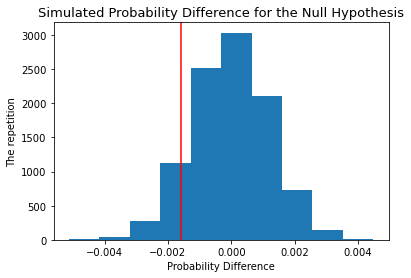

In [26]:
# convert to numpy array
p_diffs=np.array(p_diffs)
# create distribution under the null hypothesis
null_vals = np.random.normal(0,p_diffs.std(),p_diffs.size)
# Compute observed difference in Conversion rates 
obs_diff = p_treatment - p_control
# plot null distribution
plt.hist(null_vals);
# plot line for observed statistic
plt.axvline(x=obs_diff, color='red');
plt.title("Simulated Probability Difference for the Null Hypothesis",fontsize=13);
plt.xlabel('Probability Difference');
plt.ylabel('The repetition');


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
# compute p value
(p_diffs > obs_diff).mean()

0.9083

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**we learned that " p-value are the probability of observing your data or something more extreme in favor of the alternative given the null hypothesis is true".lesson12(n38) and with our case the p-value is(0.9028) which is greater than 0.05 (our $\alpha$), so we fail to reject the null hypothesis, we cannot assume the new page converts more users than the old page -so we keep the old page -.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old =(df2.query('landing_page=="old_page"'))['converted'].sum()
convert_new =(df2.query('landing_page=="new_page"'))['converted'].sum()
n_old =n_control
n_new =n_treatment 

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_stat, p_val=sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_stat, p_val

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-stat of -1.3109 represents the number of standard deviations the value of the statistic or the observed difference between the new page and old page conversion rates, is from the mean.for this test we have picked a significance level. Let's just say it's 95%(1-(α = 0.05)). Since this is a test for the difference, it's a two-tail test so a z-stat between -1.96 and +1.96 will be significant. [pro.arcgis](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm) .The conversion rate of the new landing page is only -1.3109 standard deviations from the conversion rate of the old landing page.This is less than the critical value of 1.96.therefore, we would fail to reject the Null  hypothesis, which is consistent with the results in parts j & k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**In our case, we predict tow outcomes (conversion or no conversion), so the appropriate approach is Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop('old_page', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [31]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-08-27 06:59 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The difference is, in part II, we performed a one-sided test, where in the logistic regression Part III, it is two-sided test and the hypotheses for Part III is:

- null Hypotheses: **$p_{new}$** -  **$p_{old}$** = 0
- alternative Hypotheses: **$p_{new}$** -  **$p_{old}$** != 0

The p-value associated with the variable ab_page is 0.1899 and still greater then 0.05 (our $\alpha$), so we still cannot reject our null hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- Considering other factors is a good idea as these factors may contribute to the significance of our test results and leads to more accurate decisions. The convert rate may be related to some features of users like prior academic background, age, gender or duration in page, Adding this information about users may reveal the hidden value of the new version of the page to a specific group of users.
- But The key to a successful logistic regression model is to choose the correct variables to enter into the model. While it is tempting to include as many input variables as possible, this can dilute true associations and lead to large standard errors with wide and imprecise confidence intervals, or, conversely, identify spurious associations.[Choosing the right predictor variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543767/)

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [33]:
countries_df=pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [34]:
#Check what countries are in the countries dataset
countries_df['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [35]:
df3= countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [36]:
#create dummy variables for country column
df3[['CA','UK', 'US']] = pd.get_dummies(df3['country'])
df3 = df3.drop('CA',axis=1)
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [38]:
log_mod2 = sm.Logit(df3['converted'], df3[['intercept','UK','US']])
results = log_mod2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-08-27 07:13 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

The p-values for the countries UK is 0.0740 and US is 0.1291 both of them are above 0.05, so again we cannot reject the null hypothesis. Countries do not influence significantly differences in the conversion rates.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
df3['UKab_page'] = df3['UK'] * df3['ab_page']
df3['USab_page'] = df3['US'] * df3['ab_page']
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,UKab_page,USab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,1,0


In [40]:
log_mod3 = sm.Logit(df3['converted'], df3[['intercept','UKab_page','USab_page']])
results = log_mod3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.7674
Date:               2021-08-27 07:37 BIC:              212813.5064
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.31643    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9926    0.0079  -252.9104  0.0000  -2.0081  -1.9772
UKab_page     0.0112    0.0179     0.6256  0.5316  -0.0240   0.0464
USab_page    -0.0144    0.0125    -1.1548  0.2482  -0.0389   0.0101
==================================================================

"""

None of the variables (UKab_page) and (USab_page) have significant p-values, so again we failing to reject the null hypothesis.and we don't have sufficient evidence to say that the new page results in more conversions than the old page.

## Conclusions

The conclusion of the whole study and the general result is that we do not have sufficient evidence to suggest that the new page results in more conversions than the old one.I recommend to the e-commerce company to keep the old page. This will save time and money on creating a new page.

## Resources

- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html
- https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5543767/